In [1]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error

### Import Epigenetics and RNA-seq data

In [2]:
master_folder_path = 'Multiome'

dfs_epigenetics = {}
dfs_transcriptomics = {}

# Iterate through all subdirectories and files in the master folder
for root, dirs, files in os.walk(master_folder_path):
    # If we are at the third level of directories get the histone modification assay data
    if len(root.split("/")) == 3:
        cell_line = root.split("/")[1]
        if cell_line not in dfs_epigenetics:
            dfs_epigenetics[cell_line] = []
        for file in files:
            if file.endswith('.csv'):
                # Construct the full path to the CSV file
                csv_file_path = os.path.join(root, file)
                histone_mark = csv_file_path.split("_")[-1].strip(".csv")
        
                # Read the CSV file using pandas
                df = pd.read_csv(csv_file_path)
                df['annotation'] = df['annotation'].apply(lambda x: x.split(" (")[0])
                df['annotation'] = df['annotation'] + f"_{histone_mark}"
                dfs_epigenetics[cell_line].append(df)
    # If we are at the second level of directories get RNA seq data
    if len(root.split("/")) == 2:
        cell_line = root.split("/")[1]
        for file in files:
            if file.endswith('.tsv'):
                tsv_file_path = os.path.join(root, file)
                rna_seq = pd.read_csv(tsv_file_path, sep = '\t')
                dfs_transcriptomics[cell_line] = rna_seq

### Lets use Mammary Epithelial Cell as an example for now and create the feature matrix

In [3]:
# Take this as an example for now
df_aggregated = pd.concat(dfs_epigenetics['Mammary Epithelial Cell'])

In [4]:
df_aggregated.head()

,Unnamed: 0,seqnames,start,end,width,strand,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS
0,1,chr1,100035284,100036150,867,*,3' UTR_H3K4me2,1,100038095,100083377,45283,1,64645,ENST00000370152.8,-1945
1,2,chr1,100036465,100038061,1597,*,Promoter_H3K4me2,1,100038095,100083377,45283,1,64645,ENST00000370152.8,-34
2,3,chr1,100038100,100040871,2772,*,Promoter_H3K4me2,1,100038095,100083377,45283,1,64645,ENST00000370152.8,5
3,4,chr1,100042106,100042601,496,*,Intron_H3K4me2,1,100038095,100083377,45283,1,64645,ENST00000370152.8,4011
4,5,chr1,100042648,100042938,291,*,Intron_H3K4me2,1,100038095,100083377,45283,1,64645,ENST00000370152.8,4553


In [5]:
# Get the number of peaks per gene region
peak_count_df = df_aggregated.groupby(["geneId","annotation"],as_index=False).agg(
    peak_counts = ('annotation','size')
)

In [6]:
feature_matrix = peak_count_df.pivot_table(columns='annotation',index=['geneId'])['peak_counts']

In [7]:
feature_matrix.shape

(28763, 77)

In [8]:
feature_matrix.head()

annotation,3' UTR_H2AFZ,3' UTR_H3K27a,3' UTR_H3K27me3,3' UTR_H3K36me3,3' UTR_H3K4me1,3' UTR_H3K4me2,3' UTR_H3K4me3,3' UTR_H3K79me2,3' UTR_H3K9a,3' UTR_H3K9me3,...,Promoter_H3K27a,Promoter_H3K27me3,Promoter_H3K36me3,Promoter_H3K4me1,Promoter_H3K4me2,Promoter_H3K4me3,Promoter_H3K79me2,Promoter_H3K9a,Promoter_H3K9me3,Promoter_H4K20me1
geneId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,1.0,2.0,2.0,NaN,1.0,2.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN


### Import RNA-seq data

In [9]:
rna_seq = dfs_transcriptomics['Mammary Epithelial Cell']

In [10]:
rna_seq.shape

(59526, 17)

In [11]:
rna_seq.head()

,gene_id,transcript_id(s),length,effective_length,expected_count,TPM,FPKM,posterior_mean_count,posterior_standard_deviation_of_count,pme_TPM,pme_FPKM,TPM_ci_lower_bound,TPM_ci_upper_bound,TPM_coefficient_of_quartile_variation,FPKM_ci_lower_bound,FPKM_ci_upper_bound,FPKM_coefficient_of_quartile_variation
0,10904,10904,93.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12954,12954,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12956,12956,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12958,12958,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12960,12960,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
rna_seq['gene_id_clean'] = rna_seq['gene_id'].apply(lambda x: x.split(".")[0])

### Lets harmonizome the gene identifiers in the epigenetics data and RNA-seq data to gene names 

In [13]:
mapping = pd.read_table('mart_export_grch38.txt')

In [14]:
mapping.head()

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Gene name,NCBI gene (formerly Entrezgene) ID
0,ENSG00000210049,ENSG00000210049.1,ENST00000387314,ENST00000387314.1,MT-TF,NaN
1,ENSG00000211459,ENSG00000211459.2,ENST00000389680,ENST00000389680.2,MT-RNR1,NaN
2,ENSG00000210077,ENSG00000210077.1,ENST00000387342,ENST00000387342.1,MT-TV,NaN
3,ENSG00000210082,ENSG00000210082.2,ENST00000387347,ENST00000387347.2,MT-RNR2,NaN
4,ENSG00000209082,ENSG00000209082.1,ENST00000386347,ENST00000386347.1,MT-TL1,NaN


In [15]:
ensembl_gene_id_map = mapping.set_index('Gene stable ID').to_dict()['Gene name']
ensembl_transcript_id_map = mapping.set_index('Transcript stable ID version').to_dict()['Gene name']

# NCBI column has NaNs which turns the integers into floats, so drop NaNs, change floats --> int --> str, and create dict
ncbi_gene_id_map = mapping.dropna(subset='NCBI gene (formerly Entrezgene) ID')
ncbi_gene_id_map['NCBI gene (formerly Entrezgene) ID'] = ncbi_gene_id_map['NCBI gene (formerly Entrezgene) ID'].astype(int).astype(str)
ncbi_gene_id_map = ncbi_gene_id_map.set_index('NCBI gene (formerly Entrezgene) ID').to_dict()['Gene name']

# Combine the transcript IDs, gene IDs, and NCBI IDs dictionaries for all possible mappings
mapping_dict = ensembl_transcript_id_map | ensembl_gene_id_map | ncbi_gene_id_map 

/var/folders/p4/gdh28gk568sbf143d4p59vdw0000gq/T/ipykernel_37169/4270631737.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ncbi_gene_id_map['NCBI gene (formerly Entrezgene) ID'] = ncbi_gene_id_map['NCBI gene (formerly Entrezgene) ID'].astype(int).astype(str)


In [16]:
rna_seq['gene_name'] = rna_seq['gene_id_clean'].map(mapping_dict)
feature_matrix['gene_name'] = feature_matrix.index.astype(str).map(mapping_dict)


In [17]:
rna_seq.dropna(subset='gene_name', inplace = True)

### Create training matrix and target vector

In [18]:
data = pd.merge(feature_matrix,rna_seq[['gene_name','TPM']],on='gene_name').set_index('gene_name')

In [75]:
X, y = data.iloc[:, :-1], data.iloc[:, -1]
X.fillna(0, inplace = True)

/var/folders/p4/gdh28gk568sbf143d4p59vdw0000gq/T/ipykernel_37169/225978411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace = True)


In [76]:
y = np.log10(y+0.001)

In [77]:
y.describe()

count    23306.000000
mean        -0.510815
std          1.875875
min         -3.000000
25%         -3.000000
50%          0.117603
75%          1.134448
max          5.390117
Name: TPM, dtype: float64

In [78]:
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold, cross_val_score
model = xgb.XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean MAE: 0.732 (0.017)


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [80]:
# define model
model = xgb.XGBRegressor()
# fit model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [81]:
yhat = model.predict(X_test)

In [82]:
mean_absolute_error(y_test,yhat)

0.7356855619102489

In [83]:
y_preds = pd.Series(yhat)
y_preds.index = y_test.index

In [84]:
scatter_data = pd.concat([y_test,y_preds], axis = 1).rename({'TPM':'y_true',0:'y_pred'},axis=1)

<Axes: xlabel='y_true', ylabel='y_pred'>

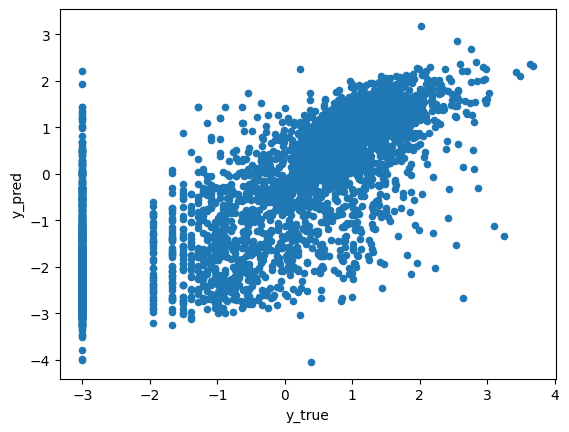

In [85]:
scatter_data.plot(kind='scatter', x = 'y_true', y= 'y_pred')